# Compression Method

we chose to use 'Universal Sentence Encoder' (https://arxiv.org/abs/1803.11175) as the selected method of compression.

## Main Idea

Design an encoder that summarizes given sentence to a 512-dimensional sentence embedding.<br> 
This embedding is used to solve multiple tasks and based on the mistakes it makes on those, the sentence embedding is updated.<br> 
Since the embedding works on multiple generic tasks, it captures only the most informative features and discard noise.<br> 
This will result in an generic embedding that transfers universally to wide variety of NLP tasks.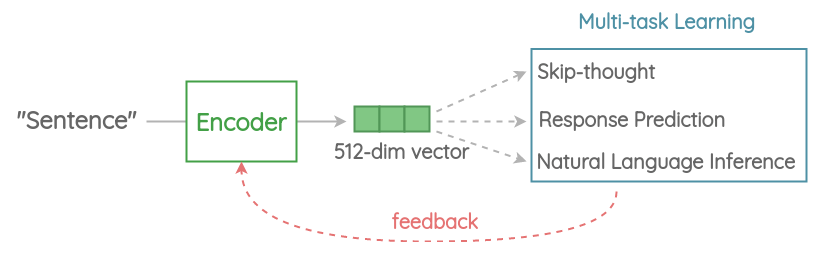

## Detailed Explaination

### Tokenizer

the sentences are converted to lowercase and tokenized into tokens using PTB tokenizer.

### Encoder

This component encodes a sentence into fixed-length 512-dimension embedding.<br> In the paper, there are two architectures proposed based on trade-offs in accuracy vs inference speed.<br>

#### Transformer

When *universal-sentence-encoder-large* model is used, it is trained with a Transformer encoder.<br>
The encoder part of the original transformer architecture is used.<br> 
The architecture consists of 6 stacked transformer layers. Each layer has a self-attention module followed by a feed-forward network.

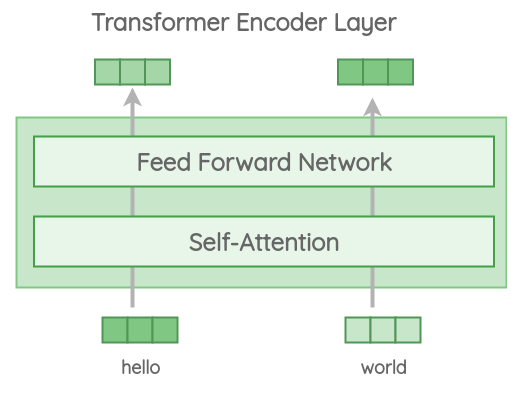

The self-attention process takes word order and surrounding context into account when generating each word representation.<br> 
The output context-aware word embeddings are added element-wise and divided by the square root of the length of the sentence to account for the sentence-length difference. <br>The output is a sentence embedding consists of a 512-dimensional vector.

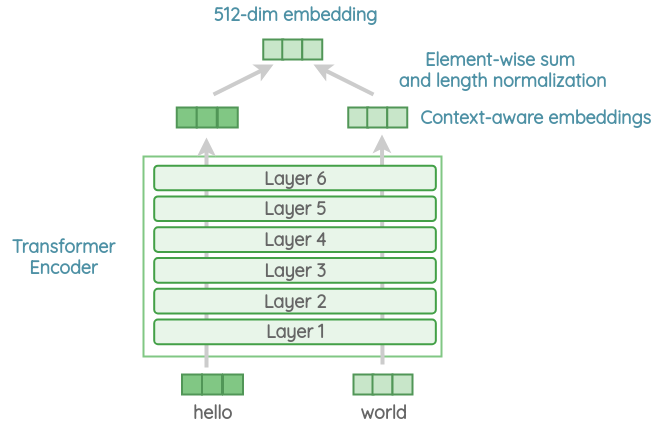

This encoder has better accuracy on downstream tasks but higher memory and compute resource usage due to complex architecture. Also, the compute time scales with the length of sentence as self-attention has O(n^2)
 time complexity with the length of the sentence.

#### DAN

This encoder is based on the architecture proposed by Iyyer (https://people.cs.umass.edu/~miyyer/pubs/2015_acl_dan.pdf).<br> 
First, the embeddings for word and bi-grams present in a sentence are averaged together. Then, they are passed through 4-layer feed-forward deep DNN to get 512-dimensional sentence embedding as output.<br> 
The embeddings for word and bi-grams are learned during training.

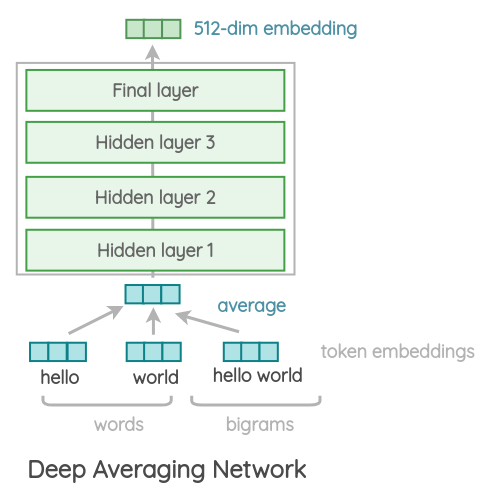

It has slightly reduced accuracy compared to the transformer variant, but the inference time is very efficient. Since we are only doing feedforward operations, the compute time is of linear complexity in terms of length of the input sequence.

### Multi-task Learning

the encoder is shared and trained across a range of unsupervised tasks along with supervised training on the SNLI corpus.

#### Modified Skip-thought

Use the current sentence to predict the previous and next sentence.<br>
In USE, only an encoder based on transformer or DAN is used. <br>
USE was trained on this task using the Wikipedia and News corpus.

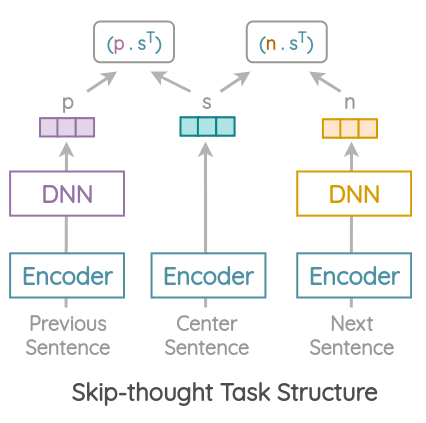

#### Conversational Input-Response Prediction

The USE authors use a corpus scraped from web question-answering pages and discussion forums and formulate this task using a sentence encoder. The input sentence is encoded into a vector u. The response is also encoded by the same encoder and response embeddings are passed through a DNN to get vector v. This is done to model the difference in meaning of input and response. The dot product of this two vectors gives the relevance of an input to response.

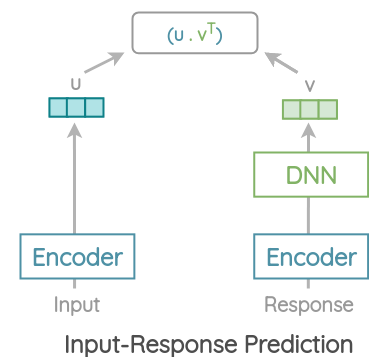

#### Natural Language Inference

Predict if a hypothesis entails, contradicts, or is neutral to a premise. The authors used the 570K sentence pairs from SNLI corpus to train USE on this task.<br>
The sentence pairs are encoded using shared Transformer/DAN encoders and the output 512-dim embeddings u1 and u2 are obtained. Then, they are concatenated along with their L1 distance and their dot product.<br> 
This concatenated vector is passed through fully-connected layers and softmax is applied to get probability for entailment/contradiction/neutral classes.

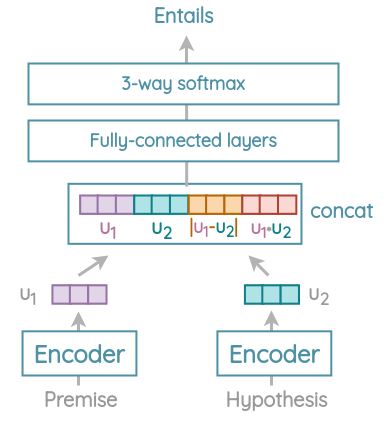

### Inference

Once the model is trained using the above tasks, it can be used to map any sentence into fixed-length 512 dimension sentence embedding. This can be used for semantic search, paraphrase detection, clustering, smart-reply, text classification, and many other NLP tasks.

## Usage Examples

In [14]:
# import shutil
# shutil.rmtree('proj')

In [15]:
import sys
import matplotlib.pyplot as plt

In [16]:
!git clone https://github.com/aviadar/covid19 proj

Cloning into 'proj'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 124 (delta 74), reused 89 (delta 39), pack-reused 0
Receiving objects: 100% (124/124), 275.71 KiB | 25.06 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [17]:
sys.path.insert(0,'/content/proj')

from utilities.sentence_utility import SentenceUtil

### Text Similarity

We used the described method in order to create sentence embedding.<br>
After have each sentece embedded into a 512 length vector, in order to get similarity, we calculate the cosine distance (or similarity) between them.
<br>(see \utilities\sentence_utility.py for more details)

In [18]:
messages = [
        # Smartphones
        "I like my phone",
        "My phone is not good.",
        "Your cellphone looks great.",

        # Weather
        "Will it snow tomorrow?",
        "Recently a lot of hurricanes have hit the US",
        "Global warming is real",

        # Food and health
        "An apple a day, keeps the doctors away",
        "Eating strawberries is healthy",
        "Is paleo better than keto?",

        # Asking about age
        "How old are you?",
        "what is your age?",
    ]

sentence_util = SentenceUtil(messages, save_input=True)
compared_index, k = 2, 3
topk_ind, topk_sim = sentence_util.get_k_most_similar(compared_index=2, k=3)

module https://tfhub.dev/google/universal-sentence-encoder-large/5 loaded


In [19]:
print('top '+ str(k) +' similarities to: ' + messages[compared_index])
for i in range(k):
    print(messages[topk_ind[i]], topk_sim[i])

top 3 similarities to: Your cellphone looks great.
I like my phone 0.5867439
My phone is not good. 0.4908851
what is your age? 0.16229782


we can see that the cosine similarity is higher, as expected, between the phone related sentences.<br>
Lets plot all similarities:

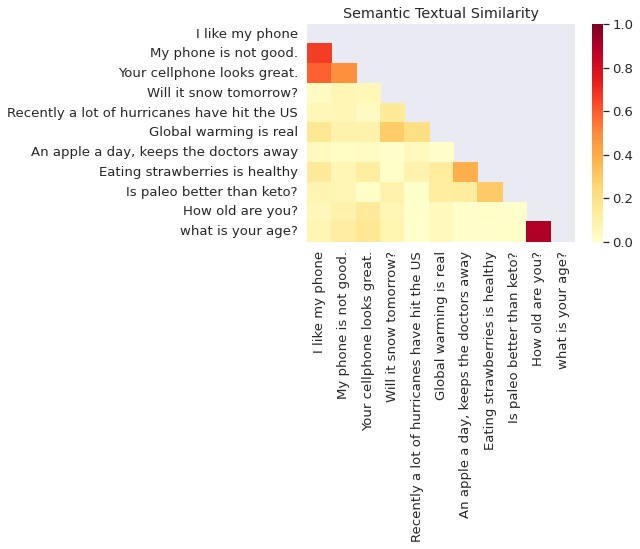

In [20]:
sentence_util.plot_similarity(labels=messages)

### Text Clustering

clustering is done by using Kmeans on the embedding using all 512 dimensions.
in order to display the data in 2D, PCA is used for dimension reduction.
(see \utilities\sentence_utility.py for more details)

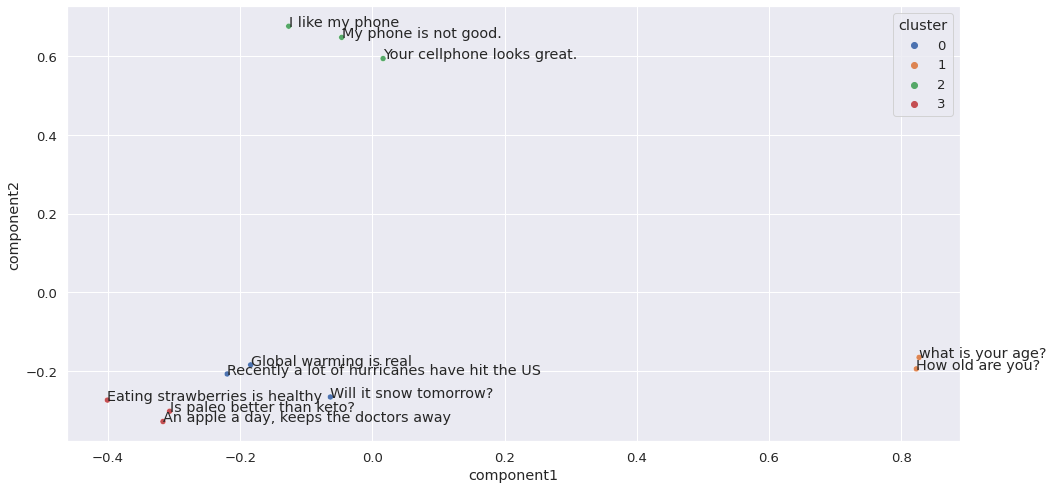

In [21]:
sentence_util.cluster_sentences(k_clusters=4)
f, ax = plt.subplots(figsize=(16, 8))
sentence_util.plot_clusters()